In [1]:
#Import data and play

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy import stats



In [2]:
#ran morph analysis in two batches, combine outputs
#load
file_1 = np.load('results_1.npy', allow_pickle=True).item()
file_2 = np.load('./done_2/results.npy', allow_pickle=True).item()

#combine
combined_files = file_1.copy()
combined_files.update(file_2)  # add all keys from data_1 to combined_data

#save
np.save('combined_results.npy', combined_files)

#renamer for below use
data = combined_files

In [3]:
# convert to pandas dataframe
rows = []
for image_file, image_data in data.items():
    base = {
        'Image_Name': image_data['Image_Name'],
        'Image_Tag': image_data['Image_Tag'],
    }
    info = image_data['info']
    # Merge the top-level and info dictionaries
    combined = {**base, **info}
    rows.append(combined)

# Convert to DataFrame
df = pd.DataFrame(rows)


In [245]:
#moving images that have already been processed if other kernel dies
'''
import shutil
import os
# List of filenames to move
files_to_move = df['Image_Name']
source_dir = './'
target_dir = './done_2'

# Create target folder if it doesn't exist
os.makedirs(target_dir, exist_ok=True)

for fname in files_to_move:
    src = os.path.join(source_dir, fname)
    dst = os.path.join(target_dir, fname)
    shutil.move(src, dst)


'''

In [4]:
#adding sphere stuff i forgot and removing clathrin 

df['Sphere_Volume'] = (4/3) * np.pi * df['sphere_radius']**3
df['Sphere_Surface_Area'] = 4 * np.pi * df['sphere_radius']**2

df = df[~df['Image_Tag'].str.contains('Clath', na=False)]

In [5]:
#add manual label of vesicle vs bud

excel_df = pd.read_excel('vesiclesvsbuds.xlsx')
df = df.merge(excel_df, on='Image_Name', how='left') 

/camp/apps/eb/software/Anaconda3/2024.10-1/lib/python3.12/site-packages/openpyxl/worksheet/_read_only.py:85: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
# Select the appropriate volume based on the Ellipsoid/Sphere choice
df['Selected_Volume'] = df.apply(
    lambda row: row['Ellipsoid_Volume_nm'] if row['Ellipsoid/Sphere'] == 'Ellipsoid' else row['Sphere_Volume'],
    axis=1
)

# Select the appropriate rmse based on the Ellipsoid/Sphere choice
df['Selected_RMSE'] = df.apply(
    lambda row: row['ellipsoid_rmse'] if row['Ellipsoid/Sphere'] == 'Ellipsoid' else row['sphere_rmse'],
    axis=1
)

# Select the appropriate sphericity based on the Ellipsoid/Sphere choice
df['Selected_sphericity'] = df.apply(
    lambda row: row['sphericity_index'] if row['Ellipsoid/Sphere'] == 'Ellipsoid' else 1,
    axis=1
)

In [ ]:
#figuring out volume error for ellipsoid and sphere

In [7]:
def compute_R_and_volume_error(row):
    # unpack ellipsoid semi-axes (a,b,c)
    a, b, c = row['ellipsoid_axes']
    
    # average radius
    R = np.mean([a, b, c])
    
    # calculate volume error estimate
    volume_error = row['Ellipsoid_Volume'] * 3 * (row['ellipsoid_rmse'] / R)
    
    return pd.Series({'R': R, 'Ellipsoid_Volume_Error': volume_error})


In [8]:
df[['R', 'Ellipsoid_Volume_Error']] = df.apply(compute_R_and_volume_error, axis=1)



In [9]:
def compute_sphere_R_and_volume_error(row):
    R = row['sphere_radius']  # radius of the sphere
    volume_error = row['Sphere_Volume'] * 3 * (row['sphere_rmse'] / R)
    return pd.Series({'Sphere_Volume_Error': volume_error})

In [10]:
df[['Sphere_Volume_Error']] = df.apply(compute_sphere_R_and_volume_error, axis=1)


In [11]:
print(df)

                                  Image_Name Image_Tag  \
0        High_mag_L12_P1_2_memb_7_2-COP1.mrc      COP1   
1       L7_LOW_1_3_HIGH_1_memb_10_1-COP2.mrc      COP2   
2         L25_LOW_2_HIGH_1_memb_1_1-COP2.mrc      COP2   
3       L39_LOW_1_7_HIGH_1_memb_1_2-COP1.mrc      COP1   
4    L24_LOW_2_4_HIGH_1_3_memb_32_2-COP1.mrc      COP1   
..                                       ...       ...   
342  L19_LOW_1_6_HIGH_1_2_memb_14_1-COP1.mrc      COP1   
343      High_mag_L12_P1_2_memb_7_6-COP1.mrc      COP1   
344    L19_LOW_1_3_HIGH_1_memb_45_1-COP2.mrc      COP2   
345   L17_LOW_1_2_HIGH_1_4_memb_2_4-COP1.mrc      COP1   
346  L13_LOW_1_3_HIGH_1_3_memb_57_1-COP2.mrc      COP2   

                                         sphere_center  sphere_radius  \
0    [313.79052959253664, 519.2613499765491, 268.80...      25.692638   
1    [240.23656620297493, 691.3410648197266, 203.40...      26.746353   
2    [147.87288003814825, 101.3373338732534, 177.22...      27.963003   
3    [368.0

In [406]:
# Filter the row with the given image_name
image_name = 'Position_14_memb_99_1-COP1.mrc'
row = df[df['Image_Name'] == image_name]
print(row)
# if not row.empty:
#     rmse_value = row['ellipsoid_rmse'].values[0]  # get the rmse value
#     print(f"eRMSE for {image_name}: {rmse_value}")
#     rmse_value = row['sphere_rmse'].values[0]  # get the rmse value
#     print(f"sRMSE for {image_name}: {rmse_value}")
# else:
#     print(f"Image name '{image_name}' not found in the DataFrame.")

                        Image_Name Image_Tag  \
49  Position_14_memb_99_1-COP1.mrc      COP1   

                                        sphere_center  sphere_radius  \
49  [655.3196885099921, 176.82677764847415, 144.45...       79.42382   

    sphere_rmse  sphere_radius_nm  \
49     6.646896          79.42382   

                                     ellipsoid_center  \
49  [666.4210140990151, 212.57270508627374, 154.64...   

                                       ellipsoid_axes  \
49  [82.3446492651379, 44.44904967067368, 36.03832...   

                                     ellipsoid_rotmat  ellipsoid_residual  \
49  [[-0.8803280723293717, 0.2659820609568782, -0....            0.000023   

    ... Sphere_Surface_Area  Unnamed: 0  Bud/Vesicle  Ellipsoid/Sphere  \
49  ...        79270.464901         NaN          Bud         Ellipsoid   

   Selected_Volume  Selected_RMSE  Selected_sphericity          R  \
49   552523.972256       4.039578             0.707963  54.277343   

    Ellips

In [ ]:
#Plotting

In [12]:
palette = {'COP1': '#E4A8E2', 'COP2': '#a3d433'}

palette_2 = {'Ellipsoid': 'black', 'Sphere': 'white'}
palette_3 = {'Bud': 'black', 'Vesicle': 'white'}

palette2_errors = {'Ellipsoid': 'grey', 'Sphere': 'white'}
palette3_errors = {'Bud': 'grey', 'Vesicle': 'white'}

palette_iv = {'COP1': '#E4A8E2', 'COP2': '#a3d433','in_vitro_COP2': '#cccccc'  # grey for manual points
}



#hex codes from chimerax

In [ ]:
#All data

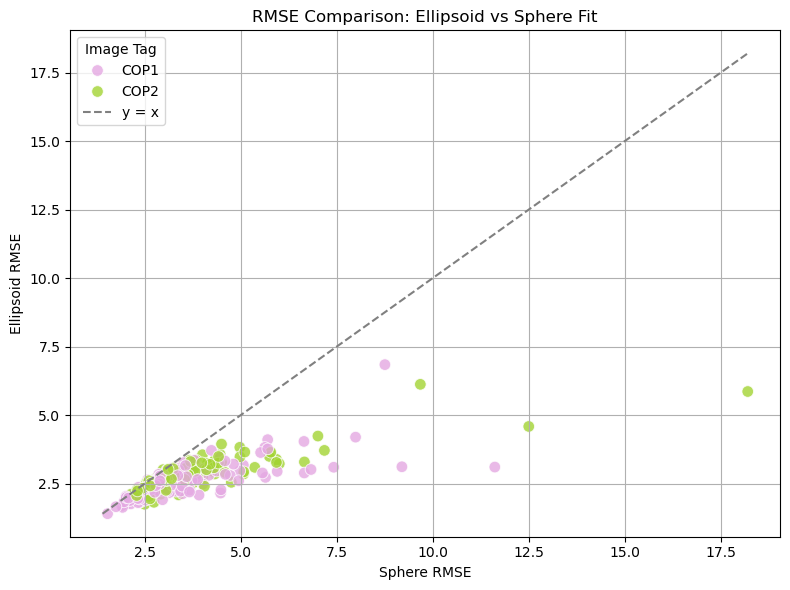

Below line = Ellipsoid is the best fit


In [13]:
plt.figure(figsize=(8,6))

# Scatter plot colored by Image_Tag
sns.scatterplot(
    data=df,
    x='sphere_rmse',
    y='ellipsoid_rmse',
    hue='Image_Tag',
    palette=palette,
    s=70,
    alpha=0.8
)

# Reference y = x line
min_rmse = min(df['sphere_rmse'].min(), df['ellipsoid_rmse'].min())
max_rmse = max(df['sphere_rmse'].max(), df['ellipsoid_rmse'].max())

plt.plot([min_rmse, max_rmse], [min_rmse, max_rmse],
         linestyle='--', color='gray', label='y = x')

plt.xlabel('Sphere RMSE')
plt.ylabel('Ellipsoid RMSE')
plt.title('RMSE Comparison: Ellipsoid vs Sphere Fit')
plt.legend(title='Image Tag')
plt.grid(True)
plt.tight_layout()
plt.show()

print('Below line = Ellipsoid is the best fit')

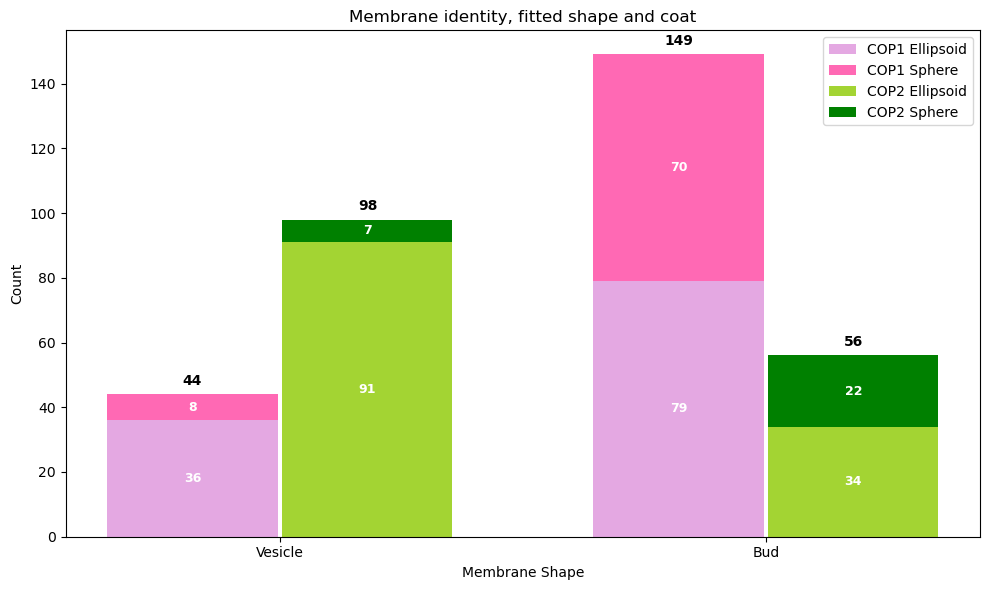

In [14]:
bud_categories = df['Bud/Vesicle'].unique()
image_tags = df['Image_Tag'].unique()

ct = pd.crosstab([df['Bud/Vesicle'], df['Image_Tag']], df['Ellipsoid/Sphere']).fillna(0)
index = pd.MultiIndex.from_product([bud_categories, image_tags], names=['Bud/Vesicle', 'Image_Tag'])
ct = ct.reindex(index, fill_value=0)

bar_width = 0.35
gap = 0.01
x = np.arange(len(bud_categories))

colors_dict = {
    'COP1': {'Ellipsoid': '#E4A8E2', 'Sphere': 'hotpink'},  
    'COP2': {'Ellipsoid': '#a3d433', 'Sphere': 'green'}  
}

fig, ax = plt.subplots(figsize=(10,6))

for i, tag in enumerate(image_tags):
    bottoms = np.zeros(len(bud_categories))
    counts_ellipsoid = []
    counts_sphere = []
    for bud in bud_categories:
        counts_ellipsoid.append(ct.loc[(bud, tag), 'Ellipsoid'] if 'Ellipsoid' in ct.columns else 0)
        counts_sphere.append(ct.loc[(bud, tag), 'Sphere'] if 'Sphere' in ct.columns else 0)

    counts_ellipsoid = np.array(counts_ellipsoid)
    counts_sphere = np.array(counts_sphere)

    bar_positions = x + i * (bar_width + gap)

    # Plot bars
    bars_ellipsoid = ax.bar(bar_positions, counts_ellipsoid, bar_width, label=f'{tag} Ellipsoid',
                           color=colors_dict[tag]['Ellipsoid'], bottom=bottoms)
    bottoms += counts_ellipsoid
    bars_sphere = ax.bar(bar_positions, counts_sphere, bar_width, label=f'{tag} Sphere',
                        color=colors_dict[tag]['Sphere'], bottom=bottoms)

    # Total counts for top labels
    totals = counts_ellipsoid + counts_sphere

    # Add individual counts inside bars (if bar is tall enough to display text)
    for bar_e, val_e, bar_s, val_s in zip(bars_ellipsoid, counts_ellipsoid, bars_sphere, counts_sphere):
        height_e = bar_e.get_height()
        height_s = bar_s.get_height()

        if height_e > 5:  # threshold to avoid clutter
            ax.text(
                bar_e.get_x() + bar_e.get_width() / 2,
                bar_e.get_y() + height_e / 2,
                f'{int(val_e)}',
                ha='center', va='center',
                fontsize=9, color='white', weight='bold'
            )
        if height_s > 5:
            ax.text(
                bar_s.get_x() + bar_s.get_width() / 2,
                bar_s.get_y() + height_s / 2,
                f'{int(val_s)}',
                ha='center', va='center',
                fontsize=9, color='white', weight='bold'
            )

    # Add total count above the stacked bar
    for pos, total in zip(bar_positions, totals):
        ax.text(
            pos,
            total + 2,  # small offset above the top
            f'{int(total)}',
            ha='center', va='bottom',
            fontsize=10, weight='bold',
            color='black'
        )

ax.set_xticks(x + (bar_width + gap) / 2)
ax.set_xticklabels(bud_categories)
ax.set_xlabel('Membrane Shape')
ax.set_ylabel('Count')
ax.set_title('Membrane identity, fitted shape and coat')

# Remove duplicate legend entries
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.tight_layout()
plt.show()


Bud/Vesicle  Bud  Vesicle
Image_Tag                
COP1         149       44
COP2          56       98


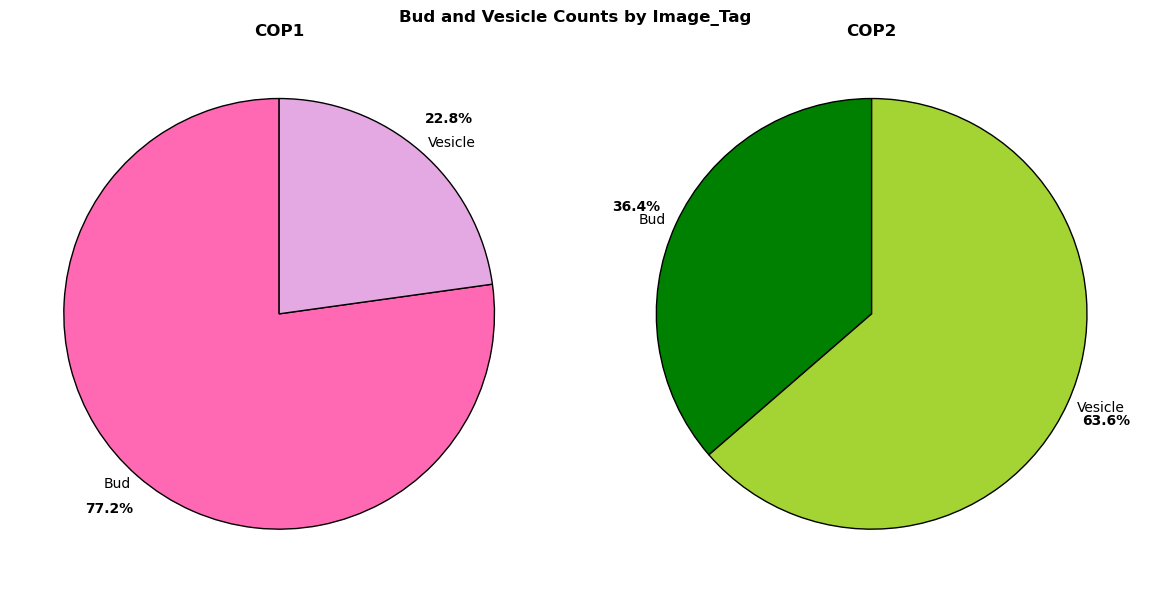

In [15]:
# Filter the dataframe for COP1 and COP2 only
df_filtered = df[df['Image_Tag'].isin(['COP1', 'COP2'])]

# Group by Image_Tag and Bud/Vesicle column, count entries
counts = df_filtered.groupby(['Image_Tag', 'Bud/Vesicle']).size().unstack(fill_value=0)

print(counts) 

# Color map as you specified
colors_map = {
    'COP1': {'Vesicle': '#E4A8E2', 'Bud': 'hotpink'},
    'COP2': {'Vesicle': '#a3d433', 'Bud': 'green'}
}

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

for i, tag in enumerate(['COP1', 'COP2']):
    sizes = counts.loc[tag]
    colors = [colors_map[tag][label] for label in sizes.index]

    wedges, texts, autotexts = axes[i].pie(
        sizes,
        labels=sizes.index,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'edgecolor': 'black'},
        pctdistance=1.2,      # Move percentage labels outside the pie
        labeldistance=1.05    # Optional: move category labels slightly outward too
    )

    # Make percentage labels a bit bolder and clearer
    for autotext in autotexts:
        autotext.set_fontweight('bold')
        autotext.set_color('black')

    axes[i].set_title(f'{tag}', fontweight='bold')

plt.suptitle('Bud and Vesicle Counts by Image_Tag', fontweight='bold')
plt.tight_layout()
plt.savefig("piechart.pdf", format='pdf', bbox_inches='tight')


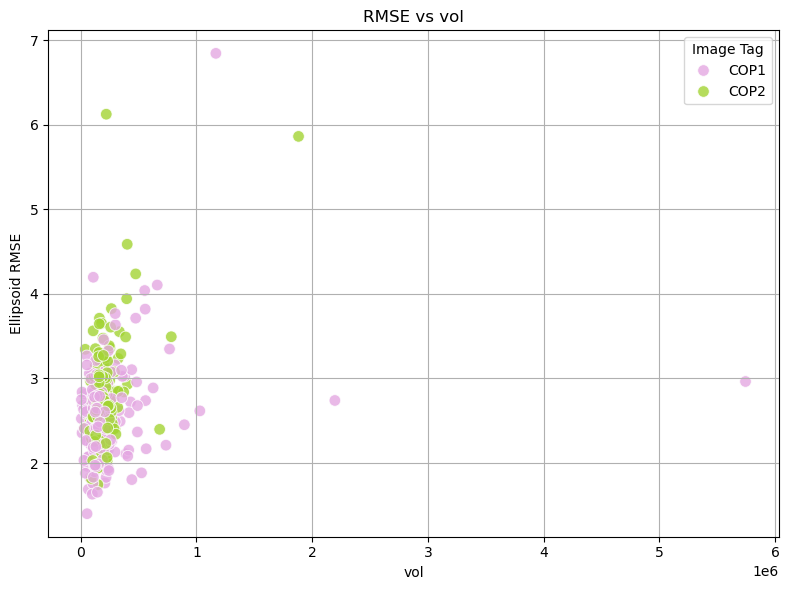

In [55]:
plt.figure(figsize=(8,6))

# Scatter plot colored by Image_Tag
sns.scatterplot(
    data=df,
    x='Ellipsoid_Volume',
    y='ellipsoid_rmse',
    hue='Image_Tag',
    palette=palette,
    s=70,
    alpha=0.8
)
plt.xlabel('vol')
plt.ylabel('Ellipsoid RMSE')
plt.title('RMSE vs vol')
plt.legend(title='Image Tag')
plt.grid(True)
plt.tight_layout()
plt.show()


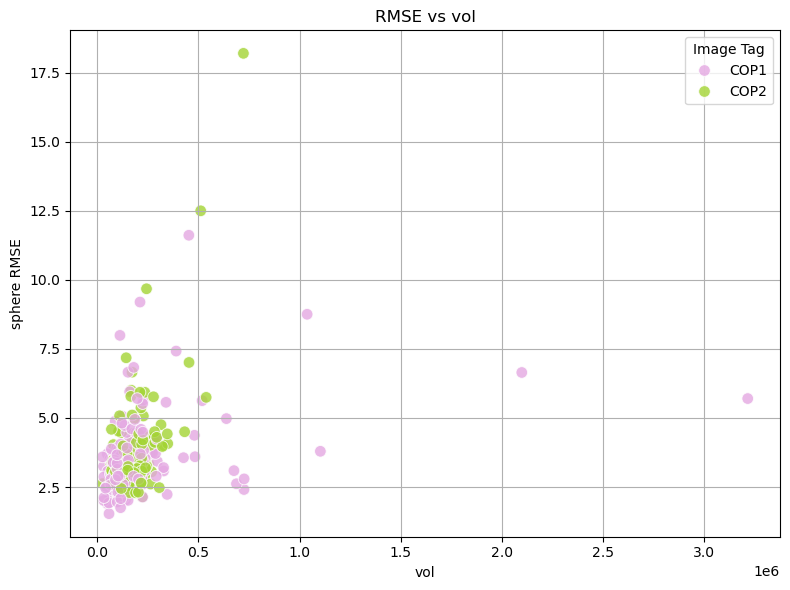

In [11]:
plt.figure(figsize=(8,6))

# Scatter plot colored by Image_Tag
sns.scatterplot(
    data=df,
    x='Sphere_Volume',
    y='sphere_rmse',
    hue='Image_Tag',
    palette=palette,
    s=70,
    alpha=0.8
)
plt.xlabel('vol')
plt.ylabel('sphere RMSE')
plt.title('RMSE vs vol')
plt.legend(title='Image Tag')
plt.grid(True)
plt.tight_layout()
plt.show()

In [56]:
high_rmse = df[(df['ellipsoid_rmse'] > 6) | (df['sphere_rmse'] > 6)]

for _, row in high_rmse.iterrows():
    print(f"{row['Image_Name']}: Ellipsoid RMSE = {row['ellipsoid_rmse']:.3f}, Sphere RMSE = {row['sphere_rmse']:.3f}")
    print('')


High_mag_L12_P1_2_memb_1_4-COP2.mrc: Ellipsoid RMSE = 3.291, Sphere RMSE = 6.658

Position_14_memb_99_1-COP1.mrc: Ellipsoid RMSE = 4.040, Sphere RMSE = 6.647

L39_LOW_4_2_HIGH_1_memb_32_2-COP2.mrc: Ellipsoid RMSE = 3.712, Sphere RMSE = 7.179

High_mag_L12_P1_2_memb_32_1-COP1.mrc: Ellipsoid RMSE = 3.115, Sphere RMSE = 9.197

Position_6_2_memb_24_1-COP1.mrc: Ellipsoid RMSE = 2.888, Sphere RMSE = 6.656

L11_HIGH_3_7_memb_13_2-COP2.mrc: Ellipsoid RMSE = 4.586, Sphere RMSE = 12.501

L29_LOW_2_2_HIGH_1_3_memb_93_1-COP1.mrc: Ellipsoid RMSE = 6.843, Sphere RMSE = 8.755

L34_LOW_1_5_HIGH_1_4_memb_11_1-COP1.mrc: Ellipsoid RMSE = 3.015, Sphere RMSE = 6.830

High_mag_L12_P1_2_memb_4_1-COP2.mrc: Ellipsoid RMSE = 3.224, Sphere RMSE = 6.004

L24_LOW_1_5_HIGH_1_memb_17_3-COP1.mrc: Ellipsoid RMSE = 4.196, Sphere RMSE = 7.991

L11_HIGH_3_7_memb_13_13-COP1.mrc: Ellipsoid RMSE = 3.104, Sphere RMSE = 11.617

Position_14_memb_91_1-COP2.mrc: Ellipsoid RMSE = 4.236, Sphere RMSE = 7.010

L31_LOW_1_3_HIGH_1_mem

Image_Tag
COP1    141447.025487
COP2    173549.844482
Name: Selected_Volume, dtype: float64

Image_Tag
COP1    3.215442e+06
COP2    7.822255e+05
Name: Selected_Volume, dtype: float64


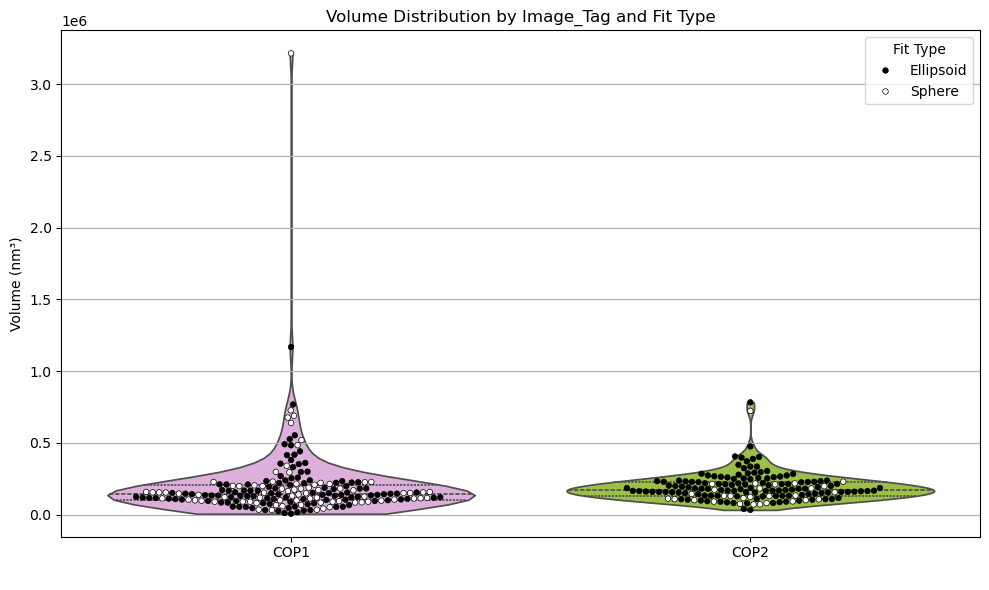

In [16]:
plt.figure(figsize=(10, 6))

sns.violinplot(
    data=df,
    x='Image_Tag',
    y='Selected_Volume',
    hue='Image_Tag',
    inner='quartile',
    cut=0,
    palette=palette
)

sns.swarmplot(
    data=df,
    x='Image_Tag',
    y='Selected_Volume',
    hue='Ellipsoid/Sphere',
    dodge=False,           # Points will overlap at the same x position
    size=4,
    # alpha=0.6,
    edgecolor='black',
    linewidth=0.5,
    palette=palette_2
)

# Remove duplicate legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Fit Type')

plt.title('Volume Distribution by Image_Tag and Fit Type')
plt.xlabel(' ')
plt.ylabel('Volume (nm³)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig("Volume.pdf", format='pdf', bbox_inches='tight')

medians = df.groupby('Image_Tag')['Selected_Volume'].median()
m = df.groupby('Image_Tag')['Selected_Volume'].max()


print(medians)
print('')
print(m)


Image_Tag
COP1    141447.025487
COP2    173549.844482
Name: Selected_Volume, dtype: float64

Image_Tag
COP1    3.215442e+06
COP2    7.822255e+05
Name: Selected_Volume, dtype: float64


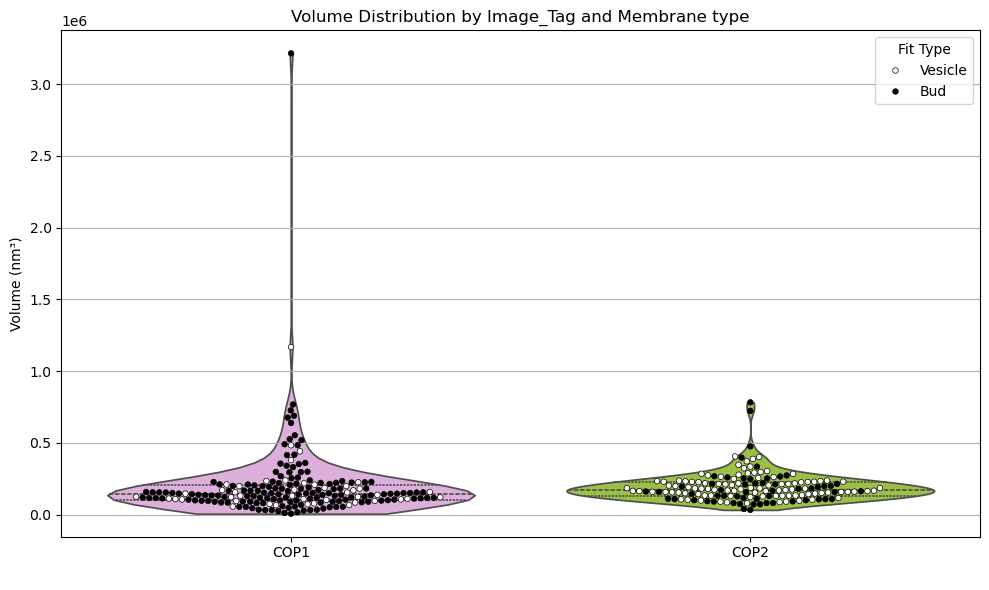

In [17]:
plt.figure(figsize=(10, 6))

sns.violinplot(
    data=df,
    x='Image_Tag',
    y='Selected_Volume',
    hue='Image_Tag',
    inner='quartile',
    cut=0,
    palette=palette
)

sns.swarmplot(
    data=df,
    x='Image_Tag',
    y='Selected_Volume',
    hue='Bud/Vesicle',
    dodge=False,           # Points will overlap at the same x position
    size=4,
    # alpha=0.6,
    edgecolor='black',
    linewidth=0.5,
    palette=palette_3
)

# Remove duplicate legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Fit Type')

plt.title('Volume Distribution by Image_Tag and Membrane type')
plt.xlabel(' ')
plt.ylabel('Volume (nm³)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig("Volume_buds_vesicles.pdf", format='pdf', bbox_inches='tight')

medians = df.groupby('Image_Tag')['Selected_Volume'].median()
m = df.groupby('Image_Tag')['Selected_Volume'].max()


print(medians)
print('')
print(m)


In [18]:
# Filter the data for COP1 and COP2 vesicles
group1 = df[df['Image_Tag'] == 'COP1']['Selected_Volume']
group2 = df[df['Image_Tag'] == 'COP2']['Selected_Volume']

# Mann-Whitney U test
u_stat, p_value_mw = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Mann-Whitney U test: U={u_stat}, p={p_value_mw}")

# Kolmogorov-Smirnov test
ks_stat, p_value_ks = stats.ks_2samp(group1, group2)
print(f"Kolmogorov-Smirnov test: KS={ks_stat}, p={p_value_ks}")

Mann-Whitney U test: U=11550.0, p=0.000362763866164767
Kolmogorov-Smirnov test: KS=0.2503869187807012, p=3.1975766743883064e-05


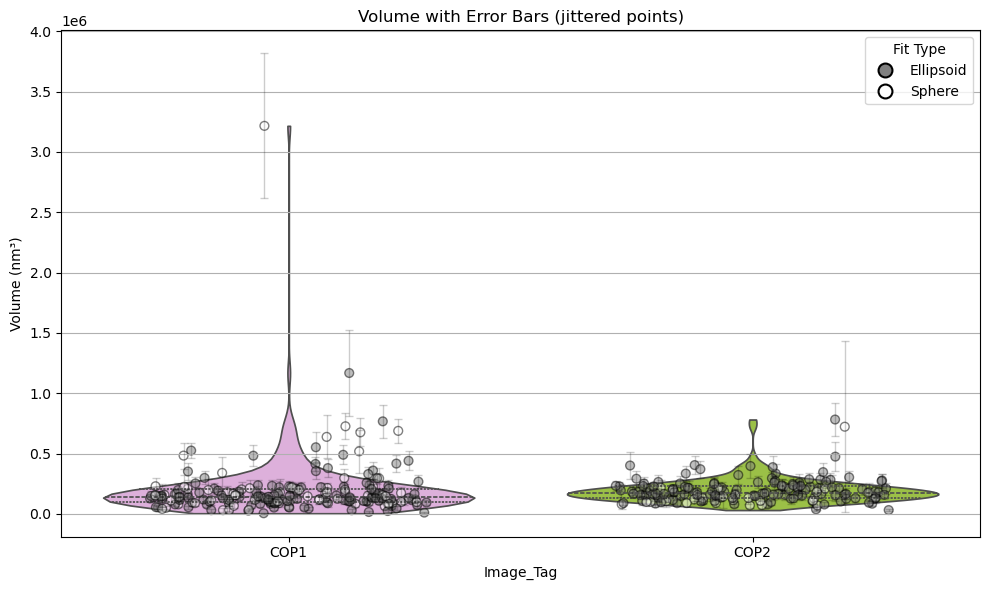

In [19]:
plt.figure(figsize=(10, 6))


# Violin or boxplot background
sns.violinplot(
    data=df,
    x='Image_Tag',
    y='Selected_Volume',
    hue='Image_Tag',
    palette=palette,
    inner='quartile',
    cut=0
)

jitter_strength = 0.3  # how much horizontal jitter

unique_tags = df['Image_Tag'].unique()

for i, tag in enumerate(unique_tags):
    sub_df = df[df['Image_Tag'] == tag]
    
    # jitter x positions around the integer i for all points of this Image_Tag
    x_jitter = i + np.random.uniform(-jitter_strength, jitter_strength, size=len(sub_df))
    
    plt.scatter(
        x_jitter,
        sub_df['Selected_Volume'],
        c=sub_df['Ellipsoid/Sphere'].map(palette2_errors),
        edgecolor='black',
        alpha=0.5,
        s=40,
    )
    
    # Plot error bars per point
    for k, (j, row) in enumerate(sub_df.iterrows()):
        yerr = row['Ellipsoid_Volume_Error'] if row['Ellipsoid/Sphere'] == 'Ellipsoid' else row['Sphere_Volume_Error']
        plt.errorbar(
            x_jitter[k],  # use 0-based index k instead of j - sub_df.index[0]
            row['Selected_Volume'],
            yerr=yerr,
            fmt='none',
            ecolor='black',
            alpha=0.2,
            capsize=3,
            elinewidth=1
        )

plt.xticks(range(len(unique_tags)), unique_tags)
plt.xlabel('Image_Tag')
plt.ylabel('Volume (nm³)')
plt.title('Volume with Error Bars (jittered points)')
plt.grid(axis='y')


ellipsoid_circle = mlines.Line2D(
    [], [], 
    color='black',             # edge color of the circle
    marker='o',                # circle marker
    markerfacecolor=palette2_errors['Ellipsoid'], 
    markeredgewidth=1.5,
    markeredgecolor='black',
    linestyle='None',
    markersize=10,
    label='Ellipsoid'
)

sphere_circle = mlines.Line2D(
    [], [], 
    color='black',
    marker='o',
    markerfacecolor=palette2_errors['Sphere'], 
    markeredgewidth=1.5,
    markeredgecolor='black',
    linestyle='None',
    markersize=10,
    label='Sphere'
)

plt.legend(handles=[ellipsoid_circle, sphere_circle], title='Fit Type')

plt.tight_layout()
plt.savefig("Volume_with_error.pdf", format='pdf', bbox_inches='tight')


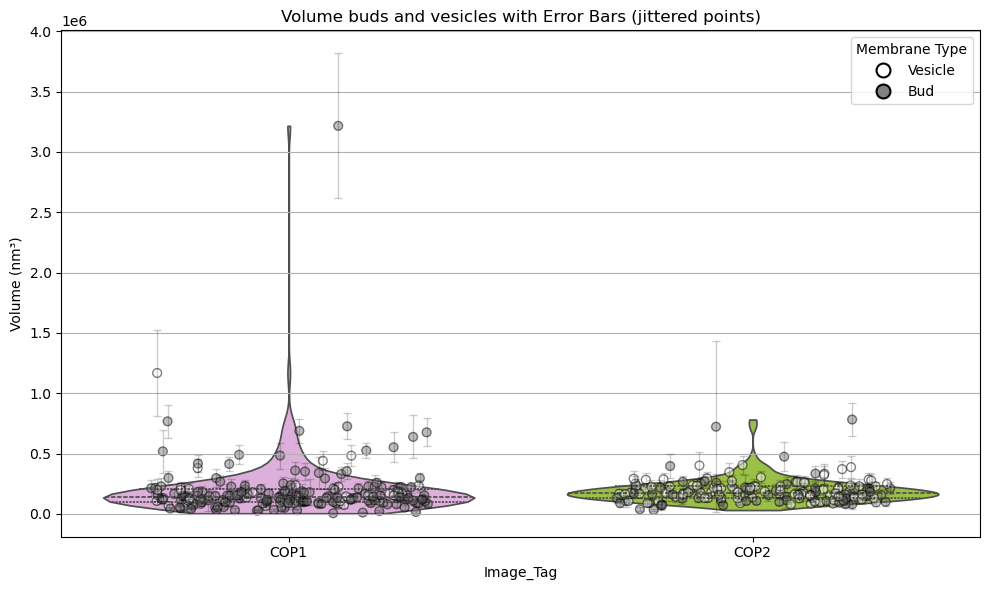

In [20]:
plt.figure(figsize=(10, 6))

# Violin or boxplot background
sns.violinplot(
    data=df,
    x='Image_Tag',
    y='Selected_Volume',
    hue='Image_Tag',
    palette=palette,
    inner='quartile',
    cut=0
)

jitter_strength = 0.3  # how much horizontal jitter

unique_tags = df['Image_Tag'].unique()

for i, tag in enumerate(unique_tags):
    sub_df = df[df['Image_Tag'] == tag]
    
    # jitter x positions around the integer i for all points of this Image_Tag
    x_jitter = i + np.random.uniform(-jitter_strength, jitter_strength, size=len(sub_df))
    
    plt.scatter(
        x_jitter,
        sub_df['Selected_Volume'],
        c=sub_df['Bud/Vesicle'].map(palette3_errors),
        edgecolor='black',
        alpha=0.5,
        s=40,
    )
    
    # Plot error bars per point
    for k, (j, row) in enumerate(sub_df.iterrows()):
        yerr = row['Ellipsoid_Volume_Error'] if row['Ellipsoid/Sphere'] == 'Ellipsoid' else row['Sphere_Volume_Error']
        plt.errorbar(
            x_jitter[k],  # use 0-based index k instead of j - sub_df.index[0]
            row['Selected_Volume'],
            yerr=yerr,
            fmt='none',
            ecolor='black',
            alpha=0.2,
            capsize=3,
            elinewidth=1
        )

plt.xticks(range(len(unique_tags)), unique_tags)
plt.xlabel('Image_Tag')
plt.ylabel('Volume (nm³)')
plt.title('Volume buds and vesicles with Error Bars (jittered points)')
plt.grid(axis='y')


ellipsoid_circle = mlines.Line2D(
    [], [], 
    color='black',             # edge color of the circle
    marker='o',                # circle marker
    markerfacecolor=palette3_errors['Vesicle'], 
    markeredgewidth=1.5,
    markeredgecolor='black',
    linestyle='None',
    markersize=10,
    label='Vesicle'
)

sphere_circle = mlines.Line2D(
    [], [], 
    color='black',
    marker='o',
    markerfacecolor=palette3_errors['Bud'], 
    markeredgewidth=1.5,
    markeredgecolor='black',
    linestyle='None',
    markersize=10,
    label='Bud'
)

plt.legend(handles=[ellipsoid_circle, sphere_circle], title='Membrane Type')

plt.tight_layout()
plt.savefig("Volume_BV_with_error.pdf", format='pdf', bbox_inches='tight')


Image_Tag
COP1    134153.399427
COP2    180761.226488
Name: Selected_Volume, dtype: float64
Image_Tag
COP1    1.167657e+06
COP2    4.046913e+05
Name: Selected_Volume, dtype: float64
Image_Tag
COP1    55264.779639
COP2    78007.628126
Name: Selected_Volume, dtype: float64
Image_Tag
COP1    105256.416281
COP2    148775.956551
Name: Selected_Volume, dtype: float64
Image_Tag
COP1    198029.576810
COP2    228868.379456
Name: Selected_Volume, dtype: float64
                              Image_Name Image_Tag  \
268  High_mag_L12_P1_2_memb_8_1-COP2.mrc      COP2   

                                         sphere_center  sphere_radius  \
268  [258.41870718215046, 479.8511340067845, 118.07...      26.393506   

     sphere_rmse  sphere_radius_nm  \
268     2.591435         26.393506   

                                      ellipsoid_center  \
268  [258.46451358071215, 479.7941834806147, 118.26...   

                                        ellipsoid_axes  \
268  [24.579226188563403, 26.6893224

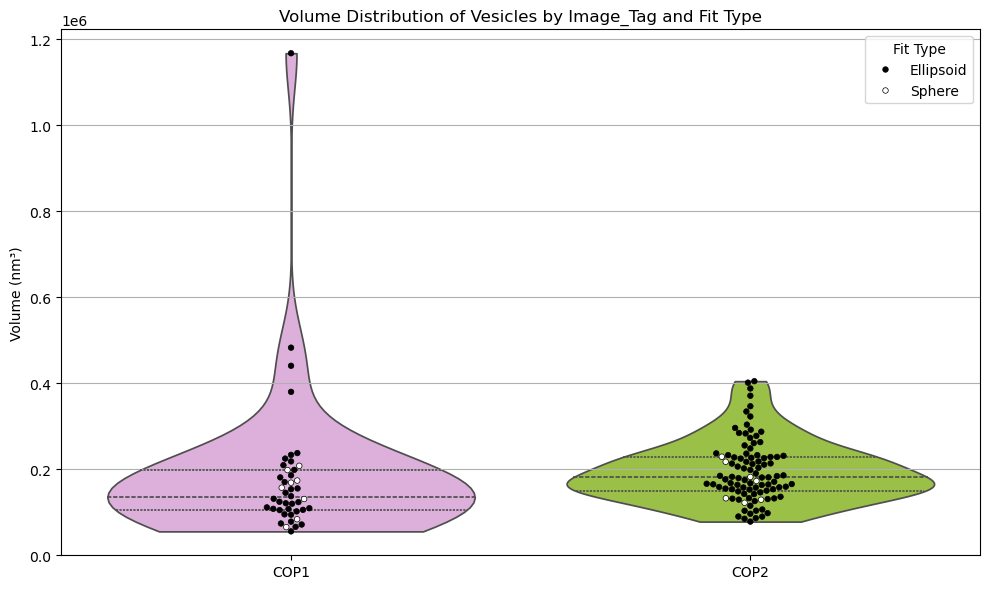

In [28]:
df_vesicles = df[df['Bud/Vesicle'] == 'Vesicle']

plt.figure(figsize=(10, 6))

sns.violinplot(
    data=df_vesicles,
    x='Image_Tag',
    y='Selected_Volume',
    hue='Image_Tag',
    inner='quartile',
    cut=0,
    palette=palette
)

sns.swarmplot(
    data=df_vesicles,
    x='Image_Tag',
    y='Selected_Volume',
    hue='Ellipsoid/Sphere',
    dodge=False,           # Points will overlap at the same x position
    size=4,
    # alpha=0.6,
    edgecolor='black',
    linewidth=0.5,
    palette=palette_2
)

# Remove duplicate legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Fit Type')

plt.title('Volume Distribution of Vesicles by Image_Tag and Fit Type')
plt.xlabel('')
plt.ylabel('Volume (nm³)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig("VesicleVol.pdf", format='pdf', bbox_inches='tight')

medians = df_vesicles.groupby('Image_Tag')['Selected_Volume'].median()

print(medians)

m = df_vesicles.groupby('Image_Tag')['Selected_Volume'].max()
print(m)

m = df_vesicles.groupby('Image_Tag')['Selected_Volume'].min()
print(m)

q1 = df_vesicles.groupby('Image_Tag')['Selected_Volume'].quantile(0.25)
q3 = df_vesicles.groupby('Image_Tag')['Selected_Volume'].quantile(0.75)
print(q1)
print(q3)

filtered_df = df_vesicles[df_vesicles['Image_Tag'] == 'COP2']

# Find the row(s) with max selected_volume in that filtered DataFrame
max_row = filtered_df[filtered_df['Selected_Volume'] == filtered_df['Selected_Volume'].min()]

with pd.option_context('display.max_columns', None, 'display.width', None):

    print(max_row)


In [21]:
#Volume of vesicles. use mann-whitney u to compare means and kolmogorov-smirnov to compare distribution

# Filter the data for COP1 and COP2 vesicles
group1 = df_vesicles[df_vesicles['Image_Tag'] == 'COP1']['Selected_Volume']
group2 = df_vesicles[df_vesicles['Image_Tag'] == 'COP2']['Selected_Volume']

# Mann-Whitney U test
u_stat, p_value_mw = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Mann-Whitney U test: U={u_stat}, p={p_value_mw}")

# Kolmogorov-Smirnov test
ks_stat, p_value_ks = stats.ks_2samp(group1, group2)
print(f"Kolmogorov-Smirnov test: KS={ks_stat}, p={p_value_ks}")


Mann-Whitney U test: U=1433.0, p=0.0014361452696430173
Kolmogorov-Smirnov test: KS=0.336734693877551, p=0.0014125559788276793


/camp/apps/eb/software/Anaconda3/2024.10-1/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 7.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


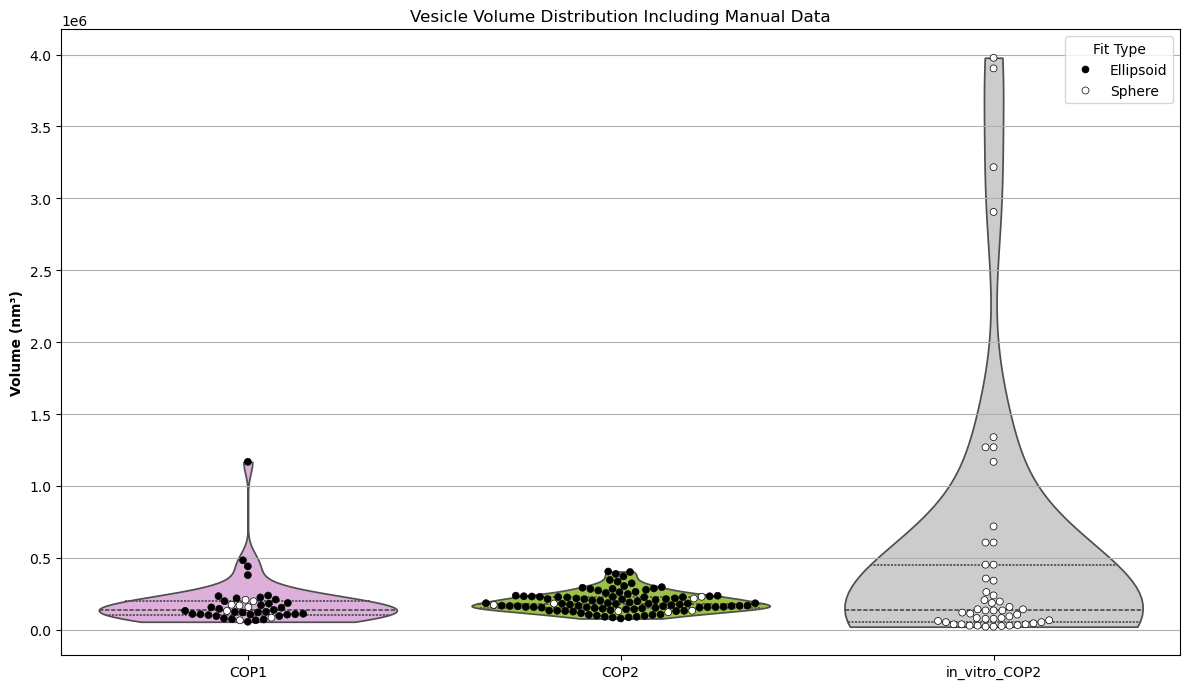

Image_Tag
COP1             134153.399427
COP2             180761.226488
in_vitro_COP2    134015.689480
Name: Selected_Volume, dtype: float64


In [22]:
#compare to euans invitro data

iv_diameter = [79.365, 72.039, 73.26, 63.492, 195.36, 64.713, 95.238, 67.155, 46.398, 183.15,
    105.006, 43.956, 177.045, 134.31, 34.188, 87.912, 64.713, 63.492, 50.061, 59.829,
    37.851, 37.851, 41.514, 36.63, 48.84, 46.398, 76.923, 111.111, 95.238, 52.503,
    58.608, 196.581, 63.492, 136.752, 134.31, 105.006, 56.166, 53.724, 41.514, 39.072,
    86.691, 61.05, 34.188, 41.514, 130.647, 53.724, 37.851, 52.503, 70.818]

df_iv_d = pd.DataFrame({'In_Vitro_Diameter': iv_diameter})

df_iv_d['In_Vitro_Volume'] = (4/3) * np.pi * (np.array(iv_diameter) / 2) ** 3


df_manual = pd.DataFrame({
    'Selected_Volume': df_iv_d['In_Vitro_Volume'],
    'Image_Tag': 'in_vitro_COP2',          # new category
    'Bud/Vesicle': 'Vesicle',
    'Ellipsoid/Sphere': 'Sphere'    # distinguish in hue or palette
})

# Combine the two DataFrames
df_combined = pd.concat([df_vesicles, df_manual], ignore_index=True)

# Plotting
plt.figure(figsize=(12, 7))

sns.violinplot(
    data=df_combined,
    x='Image_Tag',
    y='Selected_Volume',
    hue='Image_Tag',
    inner='quartile',
    cut=0,
    palette=palette_iv,
    dodge=False
)

sns.swarmplot(
    data=df_combined,
    x='Image_Tag',
    y='Selected_Volume',
    hue='Ellipsoid/Sphere',
    dodge=False,
    size=5,
    # alpha=0.7,
    edgecolor='black',
    linewidth=0.5,
    palette=palette_2
)

# Fix legend duplicates
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Fit Type')

plt.title('Vesicle Volume Distribution Including Manual Data')
plt.xlabel('')
plt.ylabel('Volume (nm³)', fontweight='bold')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig("VesicleVol_withManual.pdf", bbox_inches='tight')
plt.show()

medians = df_combined.groupby('Image_Tag')['Selected_Volume'].median()

print(medians)

In [23]:
# Filter the data for COP1 and COP2 vesicles
group1 = df_combined[df_combined['Image_Tag'] == 'COP2']['Selected_Volume']
group2 = df_combined[df_combined['Image_Tag'] == 'in_vitro_COP2']['Selected_Volume']

# Mann-Whitney U test
u_stat, p_value_mw = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Mann-Whitney U test: U={u_stat}, p={p_value_mw}")

# Kolmogorov-Smirnov test
ks_stat, p_value_ks = stats.ks_2samp(group1, group2)
print(f"Kolmogorov-Smirnov test: KS={ks_stat}, p={p_value_ks}")

Mann-Whitney U test: U=2838.0, p=0.07286678324157449
Kolmogorov-Smirnov test: KS=0.37755102040816324, p=0.00013992594190258108


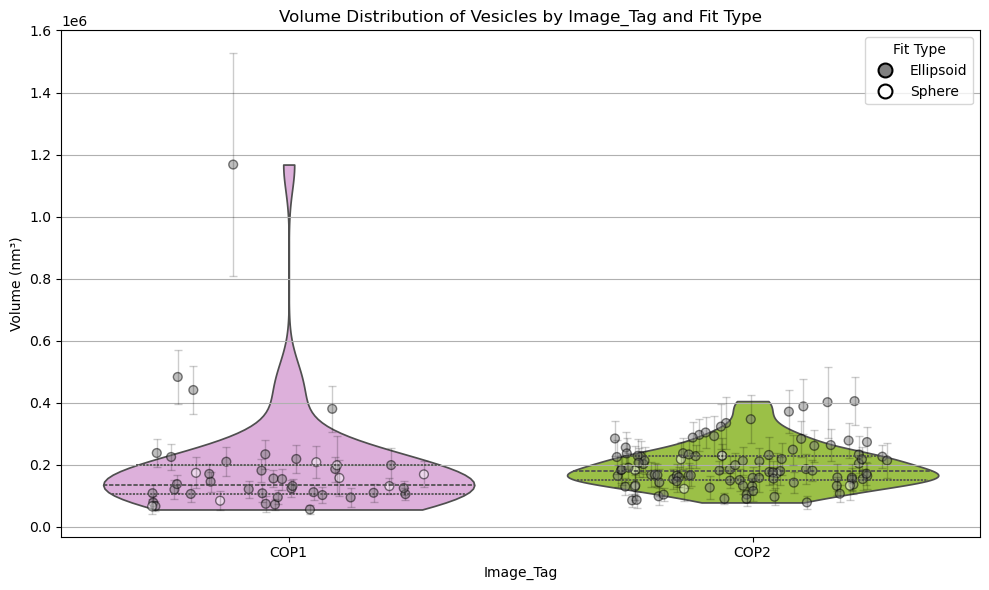

In [24]:
plt.figure(figsize=(10, 6))

# Violin or boxplot background
sns.violinplot(
    data=df_vesicles,
    x='Image_Tag',
    y='Selected_Volume',
    hue='Image_Tag',
    palette=palette,
    inner='quartile',
    cut=0
)

jitter_strength = 0.3  # how much horizontal jitter

unique_tags = df_vesicles['Image_Tag'].unique()

for i, tag in enumerate(unique_tags):
    sub_df = df_vesicles[df_vesicles['Image_Tag'] == tag]
    
    # jitter x positions around the integer i for all points of this Image_Tag
    x_jitter = i + np.random.uniform(-jitter_strength, jitter_strength, size=len(sub_df))
    
    plt.scatter(
        x_jitter,
        sub_df['Selected_Volume'],
        c=sub_df['Ellipsoid/Sphere'].map(palette2_errors),
        edgecolor='black',
        alpha=0.5,
        s=40,
    )
    
    # Plot error bars per point
    for k, (j, row) in enumerate(sub_df.iterrows()):
        yerr = row['Ellipsoid_Volume_Error'] if row['Ellipsoid/Sphere'] == 'Ellipsoid' else row['Sphere_Volume_Error']
        plt.errorbar(
            x_jitter[k],  # use 0-based index k instead of j - sub_df.index[0]
            row['Selected_Volume'],
            yerr=yerr,
            fmt='none',
            ecolor='black',
            alpha=0.2,
            capsize=3,
            elinewidth=1
        )

plt.xticks(range(len(unique_tags)), unique_tags)
plt.xlabel('Image_Tag')
plt.ylabel('Volume (nm³)')
plt.title('Volume Distribution of Vesicles by Image_Tag and Fit Type')
plt.grid(axis='y')


ellipsoid_circle = mlines.Line2D(
    [], [], 
    color='black',             # edge color of the circle
    marker='o',                # circle marker
    markerfacecolor=palette2_errors['Ellipsoid'], 
    markeredgewidth=1.5,
    markeredgecolor='black',
    linestyle='None',
    markersize=10,
    label='Ellipsoid'
)

sphere_circle = mlines.Line2D(
    [], [], 
    color='black',
    marker='o',
    markerfacecolor=palette2_errors['Sphere'], 
    markeredgewidth=1.5,
    markeredgecolor='black',
    linestyle='None',
    markersize=10,
    label='Sphere'
)

plt.legend(handles=[ellipsoid_circle, sphere_circle], title='Fit Type')

plt.tight_layout()
plt.savefig("VesicleVolError.pdf", format='pdf', bbox_inches='tight')


Image_Tag
COP1    141587.093219
COP2    158885.714432
Name: Selected_Volume, dtype: float64
Image_Tag
COP1    3.215442e+06
COP2    7.822255e+05
Name: Selected_Volume, dtype: float64
Image_Tag
COP1     5560.490535
COP2    32229.663580
Name: Selected_Volume, dtype: float64
Ellipsoid/Sphere  Ellipsoid  Sphere
Image_Tag                          
COP1                     79      70
COP2                     34      22


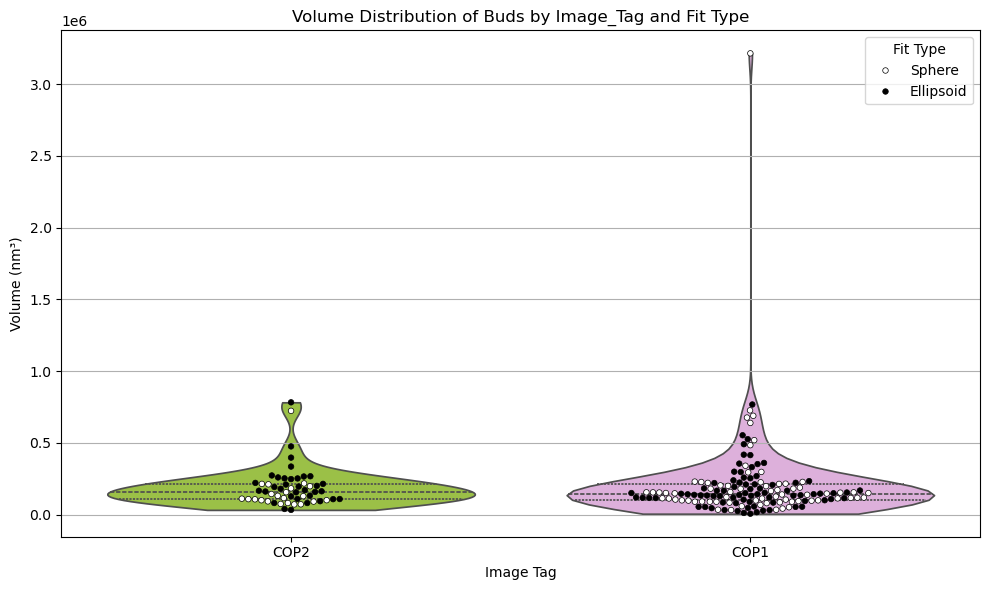

In [25]:
df_buds = df[df['Bud/Vesicle'] == 'Bud']

plt.figure(figsize=(10, 6))

sns.violinplot(
    data=df_buds,
    x='Image_Tag',
    y='Selected_Volume',
    hue='Image_Tag',
    inner='quartile',
    cut=0,
    palette=palette
)

sns.swarmplot(
    data=df_buds,
    x='Image_Tag',
    y='Selected_Volume',
    hue='Ellipsoid/Sphere',
    dodge=False,           # Points will overlap at the same x position
    size=4,
    # alpha=0.6,
    edgecolor='black',
    linewidth=0.5,
    palette=palette_2
)

# Remove duplicate legends
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Fit Type')

plt.title('Volume Distribution of Buds by Image_Tag and Fit Type')
plt.xlabel('Image Tag')
plt.ylabel('Volume (nm³)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.savefig("BudVol.pdf", format='pdf', bbox_inches='tight')

medians = df_buds.groupby('Image_Tag')['Selected_Volume'].median()
MAX = df_buds.groupby('Image_Tag')['Selected_Volume'].max()
min = df_buds.groupby('Image_Tag')['Selected_Volume'].min()


print(medians)
print(MAX)
print(min)

counts = df_buds.groupby(['Image_Tag', 'Ellipsoid/Sphere']).size().unstack(fill_value=0)
print(counts)


In [26]:
#compare median volume of buds - use same methods as vesicles 

# Filter the data for COP1 and COP2 vesicles
group1 = df_buds[df_buds['Image_Tag'] == 'COP1']['Selected_Volume']
group2 = df_buds[df_buds['Image_Tag'] == 'COP2']['Selected_Volume']

# Mann-Whitney U test
u_stat, p_value_mw = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Mann-Whitney U test: U={u_stat}, p={p_value_mw}")

# Kolmogorov-Smirnov test
ks_stat, p_value_ks = stats.ks_2samp(group1, group2)
print(f"Kolmogorov-Smirnov test: KS={ks_stat}, p={p_value_ks}")

Mann-Whitney U test: U=3842.0, p=0.3839653466268139
Kolmogorov-Smirnov test: KS=0.16430968360498563, p=0.1943226181630088


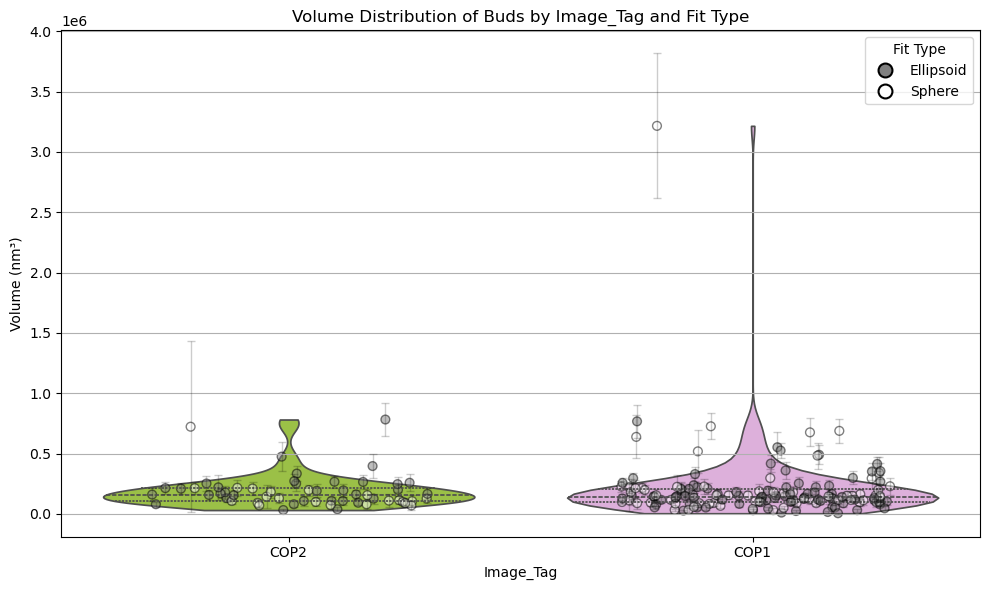

In [27]:
plt.figure(figsize=(10, 6))

# Violin or boxplot background
sns.violinplot(
    data=df_buds,
    x='Image_Tag',
    y='Selected_Volume',
    hue='Image_Tag',
    palette=palette,
    inner='quartile',
    cut=0
)

jitter_strength = 0.3  # how much horizontal jitter

unique_tags = df_buds['Image_Tag'].unique()

for i, tag in enumerate(unique_tags):
    sub_df = df_buds[df_buds['Image_Tag'] == tag]
    
    # jitter x positions around the integer i for all points of this Image_Tag
    x_jitter = i + np.random.uniform(-jitter_strength, jitter_strength, size=len(sub_df))
    
    plt.scatter(
        x_jitter,
        sub_df['Selected_Volume'],
        c=sub_df['Ellipsoid/Sphere'].map(palette2_errors),
        edgecolor='black',
        alpha=0.5,
        s=40,
    )
    
    # Plot error bars per point
    for k, (j, row) in enumerate(sub_df.iterrows()):
        yerr = row['Ellipsoid_Volume_Error'] if row['Ellipsoid/Sphere'] == 'Ellipsoid' else row['Sphere_Volume_Error']
        plt.errorbar(
            x_jitter[k],  # use 0-based index k instead of j - sub_df.index[0]
            row['Selected_Volume'],
            yerr=yerr,
            fmt='none',
            ecolor='black',
            alpha=0.2,
            capsize=3,
            elinewidth=1
        )

plt.xticks(range(len(unique_tags)), unique_tags)
plt.xlabel('Image_Tag')
plt.ylabel('Volume (nm³)')
plt.title('Volume Distribution of Buds by Image_Tag and Fit Type')
plt.grid(axis='y')


ellipsoid_circle = mlines.Line2D(
    [], [], 
    color='black',             # edge color of the circle
    marker='o',                # circle marker
    markerfacecolor=palette2_errors['Ellipsoid'], 
    markeredgewidth=1.5,
    markeredgecolor='black',
    linestyle='None',
    markersize=10,
    label='Ellipsoid'
)

sphere_circle = mlines.Line2D(
    [], [], 
    color='black',
    marker='o',
    markerfacecolor=palette2_errors['Sphere'], 
    markeredgewidth=1.5,
    markeredgecolor='black',
    linestyle='None',
    markersize=10,
    label='Sphere'
)

plt.legend(handles=[ellipsoid_circle, sphere_circle], title='Fit Type')

plt.tight_layout()
plt.savefig("BudVolError.pdf", format='pdf', bbox_inches='tight')


In [ ]:
#Ellipsoids

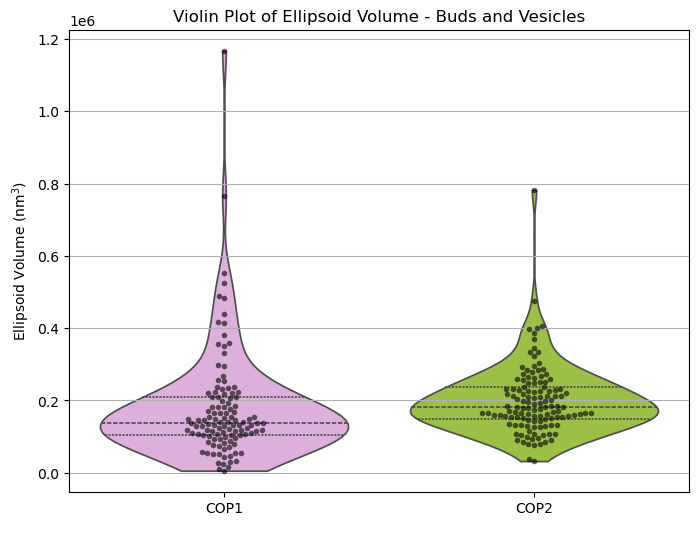

Image_Tag
COP1    137200.258338
COP2    180945.446696
Name: Ellipsoid_Volume, dtype: float64


In [122]:
df_ellipsoid = df[df['Ellipsoid/Sphere'] == 'Ellipsoid']


plt.figure(figsize=(8,6))
sns.violinplot(data=df_ellipsoid, x='Image_Tag', y='Ellipsoid_Volume', inner="quart", cut=0, palette=palette, hue='Image_Tag')
plt.title('Violin Plot of Ellipsoid Volume - Buds and Vesicles')
plt.xlabel(' ')
plt.ylabel('Ellipsoid Volume (nm$^3$)')
plt.grid(True)

sns.swarmplot(data=df_ellipsoid, x='Image_Tag', y='Ellipsoid_Volume', color='black', size=4, alpha=0.6)
# spread points horizontally to reduce overlap
plt.show()

medians = df_ellipsoid.groupby('Image_Tag')['Ellipsoid_Volume'].median()

print(medians)

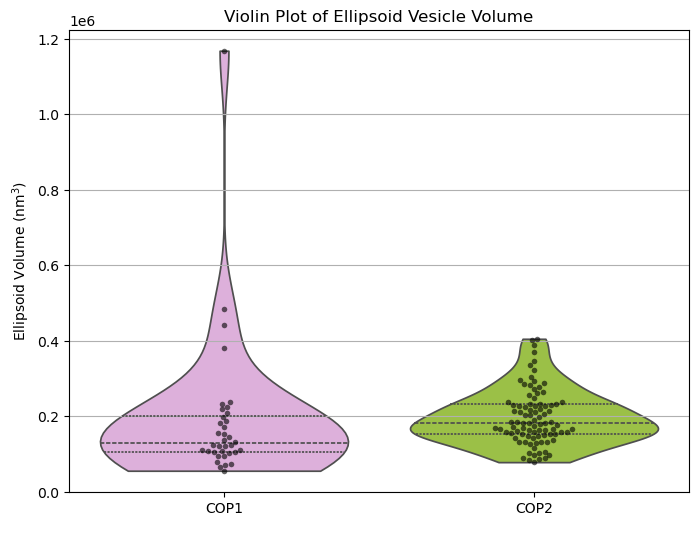

Image_Tag
COP1    127661.832930
COP2    180945.446696
Name: Ellipsoid_Volume, dtype: float64


In [123]:
df_evesicles = df_ellipsoid[df_ellipsoid['Bud/Vesicle'] == 'Vesicle']


plt.figure(figsize=(8,6))
sns.violinplot(data=df_evesicles, x='Image_Tag', y='Ellipsoid_Volume', inner="quart", cut=0, palette=palette, hue='Image_Tag')
plt.title('Violin Plot of Ellipsoid Vesicle Volume')
plt.xlabel(' ')
plt.ylabel('Ellipsoid Volume (nm$^3$)')
plt.grid(True)

sns.swarmplot(data=df_evesicles, x='Image_Tag', y='Ellipsoid_Volume', color='black', size=4, alpha=0.6)
# spread points horizontally to reduce overlap
plt.show()

medians = df_evesicles.groupby('Image_Tag')['Ellipsoid_Volume'].median()

print(medians)

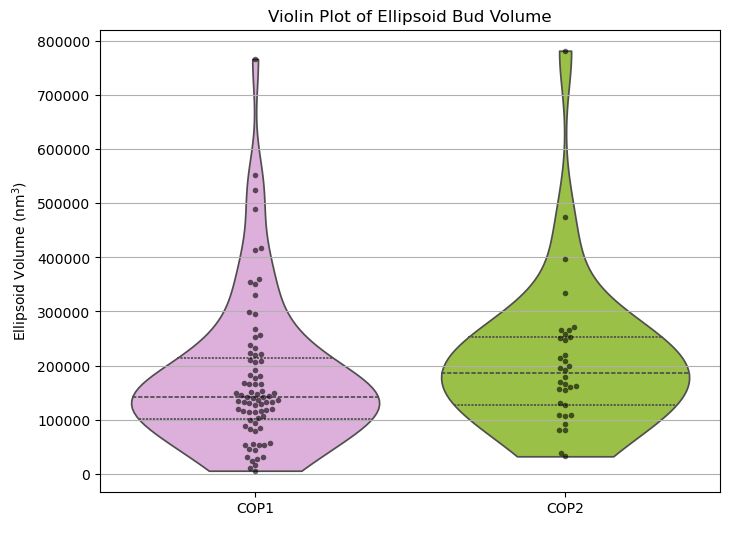

Image_Tag
COP1    141447.025487
COP2    185666.115335
Name: Ellipsoid_Volume, dtype: float64


In [124]:
df_ebuds = df_ellipsoid[df_ellipsoid['Bud/Vesicle'] == 'Bud']


plt.figure(figsize=(8,6))
sns.violinplot(data=df_ebuds, x='Image_Tag', y='Ellipsoid_Volume', inner="quart", cut=0, palette=palette, hue='Image_Tag')
plt.title('Violin Plot of Ellipsoid Bud Volume')
plt.xlabel(' ')
plt.ylabel('Ellipsoid Volume (nm$^3$)')
plt.grid(True)

sns.swarmplot(data=df_ebuds, x='Image_Tag', y='Ellipsoid_Volume', color='black', size=4, alpha=0.6)
# spread points horizontally to reduce overlap
plt.show()

medians = df_ebuds.groupby('Image_Tag')['Ellipsoid_Volume'].median()

print(medians)

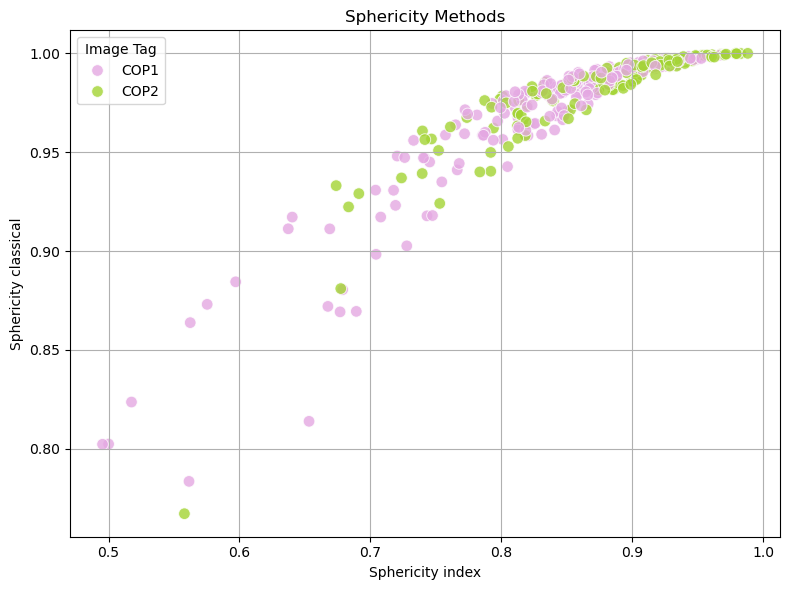

In [28]:
plt.figure(figsize=(8,6))

# Scatter plot colored by Image_Tag
sns.scatterplot(
    data=df,
    x='sphericity_index',
    y='sphericity_classical',
    hue='Image_Tag',
    palette=palette,
    s=70,
    alpha=0.8
)


plt.xlabel('Sphericity index')
plt.ylabel('Sphericity classical')
plt.title('Sphericity Methods')
plt.legend(title='Image Tag')
plt.grid(True)
plt.tight_layout()
plt.show()

/camp/apps/eb/software/Anaconda3/2024.10-1/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 20.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/camp/apps/eb/software/Anaconda3/2024.10-1/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 21.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/camp/apps/eb/software/Anaconda3/2024.10-1/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 21.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


Image_Tag
COP1    0.924762
COP2    0.916197
Name: Selected_sphericity, dtype: float64


/camp/apps/eb/software/Anaconda3/2024.10-1/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 21.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


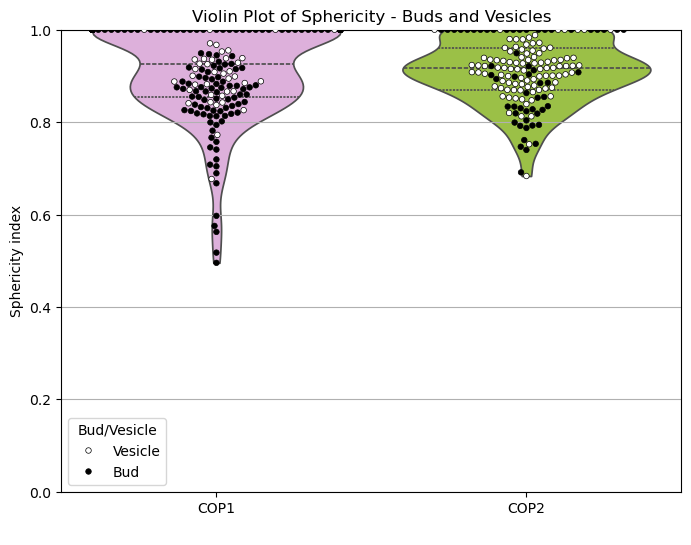

In [29]:
#sphericity
plt.figure(figsize=(8,6))
sns.violinplot(data=df, x='Image_Tag', y='Selected_sphericity', inner="quart", cut=0, palette=palette, hue='Image_Tag')
plt.title('Violin Plot of Sphericity - Buds and Vesicles')
plt.xlabel(' ')
plt.ylabel('Sphericity index')
plt.ylim(0.0, 1.0)
plt.grid(True)

sns.swarmplot(
    data=df, 
    x='Image_Tag', 
    y='Selected_sphericity', 
    hue='Bud/Vesicle', 
    size=4, 
    # alpha=0.6, 
    edgecolor='black', 
    linewidth=0.5,
    dodge=False,
    palette=palette_3
)

plt.savefig("Sphericity.pdf", format='pdf', bbox_inches='tight')

medians = df.groupby('Image_Tag')['Selected_sphericity'].median()

print(medians)

In [30]:
# Filter the data for COP1 and COP2 vesicles
group1 = df[df['Image_Tag'] == 'COP1']['Selected_sphericity']
group2 = df[df['Image_Tag'] == 'COP2']['Selected_sphericity']

# Mann-Whitney U test
u_stat, p_value_mw = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Mann-Whitney U test: U={u_stat}, p={p_value_mw}")

# Kolmogorov-Smirnov test
ks_stat, p_value_ks = stats.ks_2samp(group1, group2)
print(f"Kolmogorov-Smirnov test: KS={ks_stat}, p={p_value_ks}")

Mann-Whitney U test: U=16007.0, p=0.21044993557070335
Kolmogorov-Smirnov test: KS=0.21583338940851896, p=0.0005402762098027578


Image_Tag
COP1    0.909198
COP2    0.917766
Name: Selected_sphericity, dtype: float64


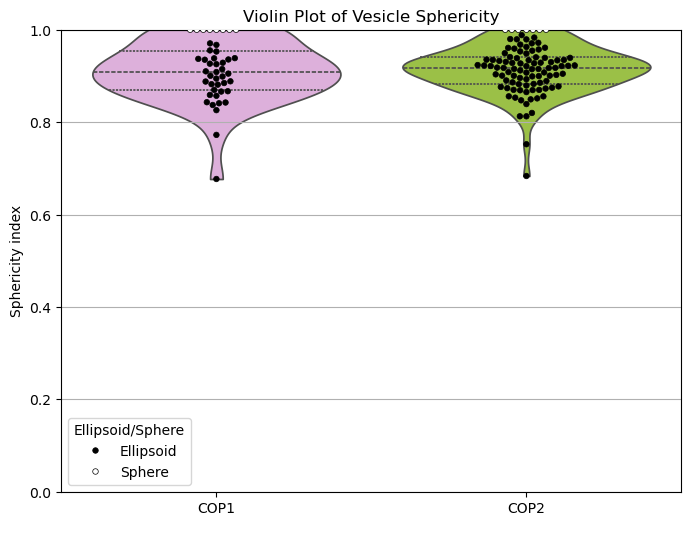

In [31]:
#sphericity of vesicles

plt.figure(figsize=(8,6))
sns.violinplot(data=df_vesicles, x='Image_Tag', y='Selected_sphericity', inner="quart", cut=0, palette=palette, hue='Image_Tag')
plt.title('Violin Plot of Vesicle Sphericity')
plt.xlabel(' ')
plt.ylabel('Sphericity index')
plt.ylim(0.0, 1.0)
plt.grid(True)

sns.swarmplot(data=df_vesicles, x='Image_Tag', y='Selected_sphericity', hue='Ellipsoid/Sphere', palette=palette_2, size=4, edgecolor='black', linewidth=0.5,)
# spread points horizontally to reduce overlap
plt.savefig("VesicleSphericity.pdf", format='pdf', bbox_inches='tight')

medians = df_vesicles.groupby('Image_Tag')['Selected_sphericity'].median()

print(medians)

In [32]:
# Filter the data for COP1 and COP2 vesicles
group1 = df_vesicles[df_vesicles['Image_Tag'] == 'COP1']['Selected_sphericity']
group2 = df_vesicles[df_vesicles['Image_Tag'] == 'COP2']['Selected_sphericity']

# Mann-Whitney U test
u_stat, p_value_mw = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Mann-Whitney U test: U={u_stat}, p={p_value_mw}")

# Kolmogorov-Smirnov test
ks_stat, p_value_ks = stats.ks_2samp(group1, group2)
print(f"Kolmogorov-Smirnov test: KS={ks_stat}, p={p_value_ks}")

Mann-Whitney U test: U=2077.0, p=0.7289642112932535
Kolmogorov-Smirnov test: KS=0.11966604823747681, p=0.7232490143868409


/camp/apps/eb/software/Anaconda3/2024.10-1/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 20.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/camp/apps/eb/software/Anaconda3/2024.10-1/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 22.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/camp/apps/eb/software/Anaconda3/2024.10-1/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 22.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/camp/apps/eb/software/Anaconda3/2024.10-1/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 22.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, U

Image_Tag
COP1    0.930793
COP2    0.902536
Name: Selected_sphericity, dtype: float64


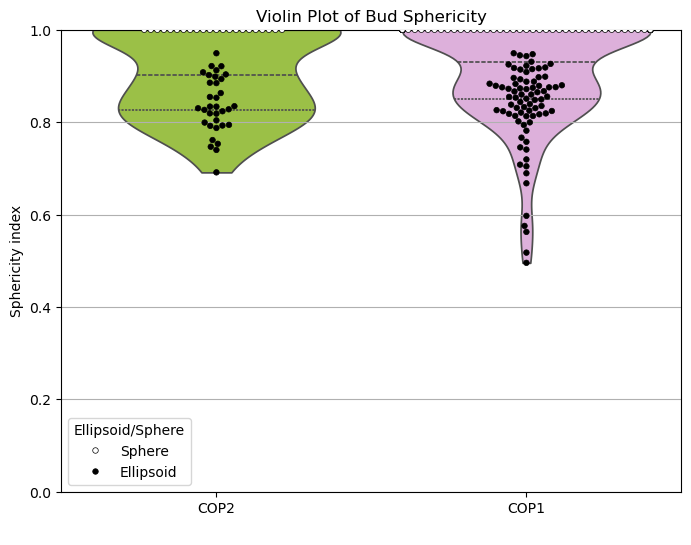

In [33]:
#sphericity of buds

plt.figure(figsize=(8,6))
sns.violinplot(data=df_buds, x='Image_Tag', y='Selected_sphericity', inner="quart", cut=0, palette=palette, hue='Image_Tag')
plt.title('Violin Plot of Bud Sphericity')
plt.xlabel(' ')
plt.ylabel('Sphericity index')
plt.ylim(0.0, 1.0)
plt.grid(True)

sns.swarmplot(data=df_buds, x='Image_Tag', y='Selected_sphericity', hue='Ellipsoid/Sphere', palette=palette_2, size=4, edgecolor='black', linewidth=0.5,)
# spread points horizontally to reduce overlap
plt.savefig("BudSphericity.pdf", format='pdf', bbox_inches='tight')

medians = df_buds.groupby('Image_Tag')['Selected_sphericity'].median()

print(medians)

In [34]:
# Filter the data for COP1 and COP2 vesicles
group1 = df_buds[df_buds['Image_Tag'] == 'COP1']['Selected_sphericity']
group2 = df_buds[df_buds['Image_Tag'] == 'COP2']['Selected_sphericity']

# Mann-Whitney U test
u_stat, p_value_mw = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Mann-Whitney U test: U={u_stat}, p={p_value_mw}")

# Kolmogorov-Smirnov test
ks_stat, p_value_ks = stats.ks_2samp(group1, group2)
print(f"Kolmogorov-Smirnov test: KS={ks_stat}, p={p_value_ks}")

Mann-Whitney U test: U=4583.0, p=0.25543760581437724
Kolmogorov-Smirnov test: KS=0.14237775647171622, p=0.3397218186400263


In [37]:
# Filter the data for COP1 and COP2 vesicles
group1 = df_buds[df_buds['Image_Tag'] == 'COP1']['Selected_sphericity']
group2 = df_vesicles[df_vesicles['Image_Tag'] == 'COP1']['Selected_sphericity']

# Mann-Whitney U test
u_stat, p_value_mw = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Mann-Whitney U test: U={u_stat}, p={p_value_mw}")

# Kolmogorov-Smirnov test
ks_stat, p_value_ks = stats.ks_2samp(group1, group2)
print(f"Kolmogorov-Smirnov test: KS={ks_stat}, p={p_value_ks}")

Mann-Whitney U test: U=3573.0, p=0.34926587708222545
Kolmogorov-Smirnov test: KS=0.28798047589993897, p=0.005405589869068192


In [38]:
# Filter the data for COP1 and COP2 vesicles
group1 = df_buds[df_buds['Image_Tag'] == 'COP2']['Selected_sphericity']
group2 = df_vesicles[df_vesicles['Image_Tag'] == 'COP2']['Selected_sphericity']

# Mann-Whitney U test
u_stat, p_value_mw = stats.mannwhitneyu(group1, group2, alternative='two-sided')
print(f"Mann-Whitney U test: U={u_stat}, p={p_value_mw}")

# Kolmogorov-Smirnov test
ks_stat, p_value_ks = stats.ks_2samp(group1, group2)
print(f"Kolmogorov-Smirnov test: KS={ks_stat}, p={p_value_ks}")

Mann-Whitney U test: U=2617.0, p=0.633562984801662
Kolmogorov-Smirnov test: KS=0.32142857142857145, p=0.0009365902103842317


In [ ]:
#Spheres